In [1]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.python.keras import preprocessing
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, LSTM, Reshape

import numpy as np
import pandas as pd

In [2]:
data = pd.read_csv('data/colors.csv')
names = data['name']
data.head()

,name,red,green,blue
0,18th Century Green,165,147,68
1,1975 Earth Red,123,70,59
2,1989 Miami Hotline,221,51,102
3,20000 Leagues Under the Sea,25,25,112
4,3AM in Shibuya,34,85,119


#### Data Preparation

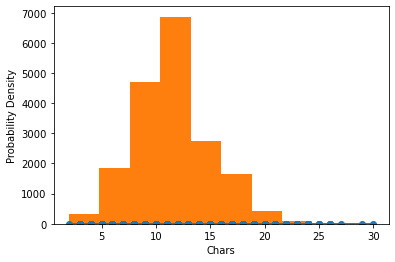

In [3]:
h = sorted(names.str.len().values)
import scipy.stats as stats
import pylab as plt

fit = stats.norm.pdf(h, np.mean(h), np.std(h)) # this is a fitting indeed
plt.plot(h, fit, '-o')
plt.hist(h) # use this to draw histogram of your data
plt.xlabel('Chars')
plt.ylabel('Probability Density')
plt.show()

In [4]:
maxlen = 25
t = Tokenizer(char_level=True)
t.fit_on_texts(names)
tokenized = t.texts_to_sequences(names)
padded_names = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
print(padded_names.shape)

(18606, 25)


#### One-Hot Endcoding

In [5]:
print(t.word_index)

{'e': 1, 'a': 2, ' ': 3, 'r': 4, 'i': 5, 'l': 6, 'n': 7, 'o': 8, 's': 9, 't': 10, 'c': 11, 'u': 12, 'd': 13, 'g': 14, 'p': 15, 'h': 16, 'b': 17, 'm': 18, 'y': 19, 'w': 20, 'k': 21, 'f': 22, 'v': 23, 'z': 24, 'j': 25, 'q': 26, 'x': 27, "'": 28, '-': 29, 'ō': 30, 'è': 31, 'é': 32, 'ā': 33, 'á': 34, 'ó': 35, 'ū': 36, '0': 37, '8': 38, '.': 39, 'ē': 40, 'ī': 41, 'ǎ': 42, '!': 43, 'í': 44, '&': 45, 'ǜ': 46, '9': 47, '2': 48, 'à': 49, 'ǐ': 50, '’': 51, '6': 52, 'ú': 53, '1': 54, '3': 55, 'â': 56, '4': 57, 'ǔ': 58, 'ì': 59, '7': 60, '5': 61, 'ê': 62, 'ö': 63, 'ł': 64, 'š': 65, 'ü': 66, '₂': 67, 'ò': 68, 'ñ': 69, 'ě': 70, 'ń': 71, 'ä': 72, 'œ': 73, 'ß': 74, '%': 75, 'ı': 76, 'ż': 77, '/': 78, 'î': 79, 'ë': 80, '(': 81, ')': 82, 'å': 83, '$': 84, 'я': 85, 'ő': 86, 'ğ': 87, 'ç': 88, 'ù': 89}


In [6]:
from tensorflow.python.keras.utils import np_utils
one_hot_names = np_utils.to_categorical(padded_names)

In [7]:
one_hot_names.shape

(18606, 25, 90)

#### Data Normalization

In [8]:
# the RGB values are between 0 - 255
# scale them to be between 0 - 1
def norm(value):
    return value / 255.0

normalized_values = np.column_stack([norm(data['red']), norm(data['green']), norm(data['blue'])])

#### Building the Model

In [9]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(maxlen, 90)))
model.add(LSTM(128))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [10]:
history = model.fit(one_hot_names, normalized_values,
                   epochs=40,
                   batch_size=32,
                   validation_split=0.2)

Epoch 1/40
466/466 [==============================] - 45s 97ms/step - loss: 0.0690 - acc: 0.5792 - val_loss: 0.0634 - val_acc: 0.5580
Epoch 2/40
466/466 [==============================] - 44s 94ms/step - loss: 0.0640 - acc: 0.6144 - val_loss: 0.0607 - val_acc: 0.5836
Epoch 3/40
466/466 [==============================] - 44s 94ms/step - loss: 0.0614 - acc: 0.6246 - val_loss: 0.0603 - val_acc: 0.5876
Epoch 4/40
466/466 [==============================] - 44s 95ms/step - loss: 0.0589 - acc: 0.6342 - val_loss: 0.0587 - val_acc: 0.5870
Epoch 5/40
466/466 [==============================] - 44s 94ms/step - loss: 0.0569 - acc: 0.6381 - val_loss: 0.0571 - val_acc: 0.6112
Epoch 6/40
466/466 [==============================] - 44s 94ms/step - loss: 0.0546 - acc: 0.6426 - val_loss: 0.0570 - val_acc: 0.5712
Epoch 7/40
466/466 [==============================] - 44s 94ms/step - loss: 0.0525 - acc: 0.6422 - val_loss: 0.0563 - val_acc: 0.5615
Epoch 8/40
466/466 [==============================] - 44s 94ms

#### Generate Colors

In [13]:
# plot a color image
def plot_rgb(rgb):
    data = [[rgb]]
    plt.figure(figsize=(2,2))
    plt.imshow(data, interpolation='nearest')
    plt.show()

def scale(n):
    return int(n * 255) 

def predict(name):
    name = name.lower()
    tokenized = t.texts_to_sequences([name])
    padded = preprocessing.sequence.pad_sequences(tokenized, maxlen=maxlen)
    one_hot = np_utils.to_categorical(padded, num_classes=90)
    pred = model.predict(np.array(one_hot))[0]
    r, g, b = scale(pred[0]), scale(pred[1]), scale(pred[2])
    print(name + ',', 'R,G,B:', r,g,b)
    plot_rgb(pred)

forest, R,G,B: 10 81 27


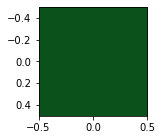

ocean, R,G,B: 16 100 140


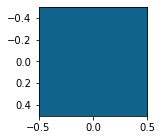

In [14]:
predict('forest')
predict('ocean')